### DECA Model with Facialis Parese

1. Follow README_Install_Mattis.md

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

Raw testing

^C
Traceback (most recent call last):
  File "/home/dietrich/Testing/DECA/demos/demo_reconstruct.py", line 23, in <module>
    import torch
  File "/home/dietrich/miniconda3/envs/deca/lib/python3.9/site-packages/torch/__init__.py", line 964, in <module>
    from . import _meta_registrations
  File "/home/dietrich/miniconda3/envs/deca/lib/python3.9/site-packages/torch/_meta_registrations.py", line 16, in <module>
    from torch._refs import _broadcast_shapes
  File "/home/dietrich/miniconda3/envs/deca/lib/python3.9/site-packages/torch/_refs/__init__.py", line 1417, in <module>
    logical_xor = _make_elementwise_binary_reference(
  File "/home/dietrich/miniconda3/envs/deca/lib/python3.9/site-packages/torch/_refs/__init__.py", line 877, in _make_elementwise_binary_reference
    register_decomposition(aten_op, disable_meta=disable_meta)(_ref)
  File "/home/dietrich/miniconda3/envs/deca/lib/python3.9/site-packages/torch/_decomp/__init__.py", line 141, in decomposition_decorator
    tree_ma

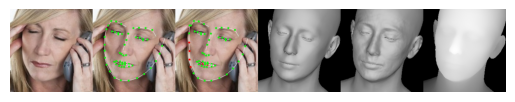

In [4]:
!CUDA_HOME=$CONDA_PREFIX python demos/demo_reconstruct.py -i TestSamples/examples --saveDepth True --saveObj True --rasterizer_type pytorch3d

image = mpimg.imread("TestSamples/examples/results/alfw1_vis.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()

Raw Testing - facialis parese patient


## Facialis Parese FLAME model with disassembled sides

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

0. Loading Image

In [ ]:
import os
input_path = "TestSamples/Brenken_Rudolf/"

input_image = "2017-04-12_007.png"

# Extrahiere den Dateinamen mit der Erweiterung
filename_with_extension = os.path.basename(input_image)

# Entferne die Dateierweiterung
filename_without_extension, extension = os.path.splitext(filename_with_extension)

# Teile die Zeichenkette am Unterstrich, um das gewünschte Datum und die Nummer zu erhalten
date_part, number_part = filename_without_extension.split("_")

print("Datum:", date_part)
print("Nummer:", number_part)

image = cv2.imread(input_path+input_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#==========Plot==========
plt.imshow(image)
plt.axis('off')
plt.show()

1. Decoupling images to left and right side

In [ ]:
import mediapipe as mp
import cv2

#Using Mediapipe to decouple the image to left and right side via the midpoints of the eyes to make it more "middle" than just using the image shape

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('uint8')

results = face_mesh.process(image_rgb)
landmarks = results.multi_face_landmarks[0].landmark

left_eye_inner = np.array([landmarks[159].x, landmarks[159].y, landmarks[159].z])
right_eye_inner = np.array([landmarks[386].x, landmarks[386].y, landmarks[386].z])

eye_midpoint = (left_eye_inner + right_eye_inner) / 2

eye_midpoint_pixel = (int(eye_midpoint[0] * image.shape[1]), int(eye_midpoint[1] * image.shape[0]))

print(eye_midpoint_pixel)

right_half = image[:, :eye_midpoint_pixel[0], :]
left_half = image[:, eye_midpoint_pixel[0]:, :]

#==========Plot==========
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(left_half)
plt.title('Left Half')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(right_half)
plt.title('Right half')
plt.axis('off')

plt.show()

2. Flipping and adjusting the images

In [ ]:
left_half_flipped = np.flip(left_half, axis=1)
right_half_flipped = np.flip(right_half, axis=1)

left_half_full_image = np.concatenate([left_half_flipped, left_half], axis=1)
right_half_full_image = np.concatenate([right_half, right_half_flipped], axis=1)

left_image_path = input_path + "left_half_full_image.png"
right_image_path = input_path + "right_half_full_image.png"

plt.imsave(left_image_path, left_half_full_image)
plt.imsave(right_image_path, right_half_full_image)

#==========Plot==========
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(left_half_full_image)
plt.title('Left Half mirrored')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(right_half_full_image)
plt.title('Right half mirrored')
plt.axis('off')

plt.show()

3. Adjusting FLAME to both sides

In [ ]:
output_path = "TestSamples/Brenken_Rudolf/results/leftright"

In [ ]:
!CUDA_HOME=$CONDA_PREFIX

In [ ]:
#--iscrop False , because else the image would be cropped and the face would not be full
%run demos/demo_reconstruct.py -i $left_image_path --saveDepth True --savefolder $output_path --saveObj True --rasterizer_type pytorch3d --render_orig True --iscrop False

image = mpimg.imread(output_path + "/left_half_full_image_vis_original_size.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
%run demos/demo_reconstruct.py -i $right_image_path --saveDepth True --savefolder $output_path --saveObj True --rasterizer_type pytorch3d --render_orig True

image = mpimg.imread(output_path + "/right_half_full_image_vis_original_size.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()

4. Bringing both sides together and building a coherent model

In [ ]:
def blending_sides(vertices_left, vertices_right, link:str):

    vertice_exp_lr = np.zeros((5023, 3))
    template_vertices = vertices_right
    vertice_max = template_vertices[:,0].max()
    vertice_min = template_vertices[:,0].min()
    vertice_diff = vertice_max - vertice_min
    print(vertice_diff)

    # Iterate through each vertex and apply the specified blending method
    for i in range(0, 5023):
        rel_dist = (template_vertices[i, 0] - vertice_min) / vertice_diff
        if link == "linear":
            vertice_exp_lr[i] = rel_dist * vertices_right[i] + (1 - rel_dist) * vertices_left[i]
        elif link == "exponential":
            rel_dist_scaled = rel_dist * 2 - 1  # Skaliere von 0-1 zu -1-1, um symmetrische Exponentialfunktion zu erhalten
            rel_dist_transformed = (np.exp(rel_dist_scaled) - 1) / (np.exp(1) - 1)  # Hier exponentielle Transformation von -1-1 auf 0-1
            vertice_exp_lr[i] = rel_dist_transformed * vertices_right[i] + (1 - rel_dist_transformed) * vertices_left[i]
        elif link == "binary":
            vertice_exp_lr[i] = vertices_right[i]+0.1*vertices_left[i] if rel_dist > 0.5 else vertices_left[i]
            
    return vertice_exp_lr

In [ ]:
import pyrender
import trimesh
def viewer(vertices, faces):
    """Interactive visualization via Pyrender Viewer of a (face) mesh

    Args:
        vertices (np.ndarray): 3D vertices of the mesh.
        faces (np.ndarray): Faces defining the mesh.

    Returns:
        None
    """
    vertex_colors = np.ones([vertices.shape[0], 4]) * [1.0, 1.0, 1.0, 1.0]

    tri_mesh = trimesh.Trimesh(vertices, faces, vertex_colors=vertex_colors)
    tri_mesh.export('output_mesh.obj')
    mesh = pyrender.Mesh.from_trimesh(tri_mesh)
    scene = pyrender.Scene()
    scene.add(mesh)
    pyrender.Viewer(scene, use_raymond_lighting=True)


In [ ]:
vertices_left = np.loadtxt(output_path+"/left_half_full_image/left_half_full_image_vertice.txt")
vertices_right = np.loadtxt(output_path+"/right_half_full_image/right_half_full_image_vertice.txt")
faces = np.loadtxt(output_path+"/left_half_full_image/left_half_full_image_faces.txt")

#Problem exponential und linear: Änderung kaum zu erkennen
vertice_lr = blending_sides(vertices_left, vertices_right, link="binary")

vertex_colors = np.ones([vertice_lr.shape[0], 4]) * [1.0, 1.0, 1.0, 1.0]
tri_mesh = trimesh.Trimesh(vertice_lr, faces, vertex_colors=vertex_colors)
viewer(vertice_lr, faces)

Building a shape and pose model and only using the expression parameters for the sides 

1. Getting a template Model without specified parameters

2. Realized: Wen need to get the expression parameters and take them to FLAME_PyTorch, so the other way around; it's easier

3. Getting the expression parameters

Left

In [1]:
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from skimage.io import imread
import torch
from tqdm import tqdm

# Beispielaufruf
image_path = left_image_path
device = 'cuda'
deca = DECA(config = deca_cfg, device='cuda')

testdata = datasets.TestData(image_path)
deca = DECA(config = deca_cfg, device=device)
# for i in range(len(testdata)):
for i in tqdm(range(len(testdata))):
    name = testdata[i]['imagename']
    images = testdata[i]['image'].to(device)[None,...]
    with torch.no_grad():
        codedict = deca.encode(images)

# Führen Sie das DECA-Modell aus, um die Expressionsparameter zu erhalten
expressions_params = codedict['exp']

# Drucken Sie die Expressionsparameter
print("Expressionsparameter:")
print(expressions_params)

torch.save(expressions_params, 'expressions_params_left.pth')

KeyboardInterrupt: 

Right

In [ ]:
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from skimage.io import imread
import torch
from tqdm import tqdm

# Beispielaufruf
image_path = f
device = 'cuda'
deca = DECA(config = deca_cfg, device='cuda')

testdata = datasets.TestData(image_path)
deca = DECA(config = deca_cfg, device=device)
# for i in range(len(testdata)):
for i in tqdm(range(len(testdata))):
    name = testdata[i]['imagename']
    images = testdata[i]['image'].to(device)[None,...]
    with torch.no_grad():
        codedict = deca.encode(images)

# Führen Sie das DECA-Modell aus, um die Expressionsparameter zu erhalten
expressions_params = codedict['exp']

# Drucken Sie die Expressionsparameter
print("Expressionsparameter:")
print(expressions_params)

torch.save(expressions_params, 'expressions_params_right.pth')

In [2]:
import DePa

!CUDA_HOME=$CONDA_PREFIX

image_path = "TestSamples/Brenken_Rudolf/2017-10-24_00-00_Brenken-Rudolf_06/2017-10-24_001.jpg"
results_path = "TestResults/testing/"

DePa.decouple(image_path, results_path)


I0000 00:00:1704891079.789130 2301860 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1704891079.792082 2302764 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) HD Graphics 4600 (HSW GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/home/dietrich/miniconda3/envs/deca/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dietrich/miniconda3/envs/deca/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


creating the FLAME Decoder
trained model found. load /home/dietrich/Testing/DECA/data/deca_model.tar


OrderedDict([('encoder.conv1.weight',
              tensor([[[[-1.0127e-02, -4.9507e-02, -2.9575e-02,  ..., -1.0279e-02,
                          4.6049e-03, -4.0324e-02],
                        [-4.6507e-03, -3.5652e-02,  5.8404e-03,  ..., -2.0408e-02,
                          1.5042e-02, -2.3465e-02],
                        [ 9.7123e-03, -1.9837e-02, -1.9679e-02,  ..., -1.1236e-02,
                          5.6221e-02,  1.2591e-02],
                        ...,
                        [-2.8070e-02,  7.8053e-03, -1.7282e-03,  ..., -3.1225e-02,
                         -1.2820e-02, -1.9333e-02],
                        [-2.7506e-02, -2.7338e-02, -2.9490e-02,  ..., -2.0821e-02,
                         -1.0050e-02, -4.2457e-04],
                        [-3.1404e-03, -1.9950e-02,  1.9223e-02,  ..., -2.4874e-02,
                         -4.6111e-02,  4.2510e-02]],
              
                       [[-3.4766e-02, -5.4713e-02,  1.3868e-02,  ...,  1.7838e-02,
                        

OrderedDict([('encoder.conv1.weight',
              tensor([[[[-3.2155e-02,  3.3220e-02,  1.2321e-02,  ..., -6.2984e-02,
                         -1.0136e-01, -1.9491e-01],
                        [-6.6464e-02,  1.3246e-02,  5.6659e-02,  ...,  7.0104e-02,
                          1.9471e-02, -1.0030e-02],
                        [-6.0737e-02,  4.2887e-03,  1.0907e-02,  ...,  8.0836e-02,
                          3.8180e-02,  5.0643e-02],
                        ...,
                        [-4.6127e-02, -2.0175e-03, -6.0551e-02,  ..., -1.3310e-01,
                         -9.8038e-02, -5.6399e-03],
                        [ 3.3635e-03,  6.4611e-02,  3.6993e-02,  ...,  2.1519e-02,
                         -2.0219e-02, -4.0211e-02],
                        [-1.3897e-01, -3.4429e-02, -7.7838e-03,  ...,  1.0858e-02,
                          1.4176e-02, -4.5842e-02]],
              
                       [[-2.3603e-02,  7.9058e-02,  1.2081e-01,  ...,  7.4113e-02,
                        

0


/home/dietrich/miniconda3/envs/deca/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:548: UserWarning: Mtl file does not exist: /home/dietrich/Testing/DECA/data/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
  0%|          | 0/1 [00:00<?, ?it/s]

'Parameters Shape: torch.Size([1, 236])'

'Parameters Shape: torch.Size([1, 128])'

  0%|          | 0/1 [00:00<?, ?it/s]

'Parameters Shape: torch.Size([1, 236])'

'Parameters Shape: torch.Size([1, 128])'

100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


Decoupling done


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import os
from DePa import decouple
import torch

!CUDA_HOME=$CONDA_PREFIX
# Ausgangsverzeichnis
base_folder = "TestSamples/Probanden"
output_base_folder = "TestResults/Probanden"

# Erstelle den Ausgabeordner, wenn er nicht existiert
if not os.path.exists(output_base_folder):
    os.makedirs(output_base_folder)

# Gehe durch alle Ordner im Ausgangsverzeichnis
for folder_name in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder_name)

    # Überprüfe, ob es sich um einen Ordner handelt
    if os.path.isdir(folder_path):
        # Erstelle den Ausgabeordner für diesen Ordner, wenn er nicht existiert
        output_folder_path = os.path.join(output_base_folder, folder_name)
        if not os.path.exists(output_folder_path):
            os.makedirs(output_folder_path)

        # Durchlaufe alle Dateien im Ordner
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            # Überprüfe, ob es sich um eine Bilddatei handelt
            if file_name.lower().endswith(('.jpg', '.JPG')):
                fn, ext = os.path.splitext(os.path.basename(file_name))
                # Erstelle den Ergebnis-Pfad für diese Datei
                result_path = os.path.join(output_folder_path, fn + "/")
                if not os.path.exists(result_path):
                    os.makedirs(result_path)
                
                print(file_path)
                print(result_path)
                # Führe die DePa.decouple-Funktion auf die Bilddatei aus
                decouple(file_path, result_path)
                torch.cuda.empty_cache()
